# Pretrain results summary

This notebook pulls specific W&B runs and compiles requested metrics into a table.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t as student_t
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
# Build bootstrap samples DataFrame for single-recording tasks
import pandas as pd
from typing import Optional
from typing import Dict, List, Tuple, Optional
import numpy as np
import wandb
import os
from scipy.stats import ttest_ind_from_stats, ttest_ind
from statsmodels.stats.multitest import multipletests 

# Build agg_df with sample lists and patch with bootstrap samples for single-recording tasks
from typing import Dict, Tuple

# Helper to safely extract nested config or summary keys

def get_summary_value(run, key):
    try:
        return run.summary.get(key, None)
    except Exception:
        return None


def star_from_p(p):
    if p < 1e-3:
        return '***'
    if p < 1e-2:
        return '**'
    if p < 0.05:
        return '*'
    return ''


def annotate_pair(ax, x1, x2, y, text, height=0.01, linewidth=1.0):
    if x2 < x1:
        x1, x2 = x2, x1
    ax.plot([x1, x1, x2, x2], [y, y + height, y + height, y], lw=linewidth, c='k')
    ax.text((x1 + x2) / 2, y + height, text, ha='center', va='bottom', fontsize=10)

# --- New factorized helpers ---
def gather_run_samples(api, project, run_display_by_label):
    """Return dict: pretty_label -> list of finished wandb.Run objects."""
    out = {}
    for label, display_name in run_display_by_label.items():
        try:
            runs = api.runs(project, filters={"display_name": display_name})
        except Exception:
            runs = []
        out[label] = list(runs)
    return out

def extract_per_recording_values(run, ds_key):
    """Collect per-recording summary values under val/r2/{ds_key}/<recording_id> and skip mean/std.
    Falls back to mean if none found for this run."""
    prefix = f"val/r2/{ds_key}/"
    vals = []
    try:
        for k, v in getattr(run, 'summary', {}).items():
            if isinstance(k, str) and k.startswith(prefix):
                suffix = k[len(prefix):]
                if suffix in ("mean", "std"):
                    continue
                try:
                    if v is not None:
                        vals.append(float(v))
                except Exception:
                    pass
        if len(vals) == 0:
            mv = run.summary.get(f"val/r2/{ds_key}/mean", None)
            if mv is not None:
                vals.append(float(mv))
    except Exception:
        pass
    return vals

def build_samples_per_model(run_samples, ds_key, results_df, run_display_by_label):
    """Return dict: pretty_label -> np.ndarray of pooled per-recording values across finished runs.
    If none found for a label, falls back to results_df mean (single value) when available."""
    samples = {}
    for label in run_display_by_label.keys():
        vals = []
        for r in run_samples.get(label, []):
            vals.extend(extract_per_recording_values(r, ds_key))
        if len(vals) == 0:
            try:
                row = results_df[results_df['run'] == run_display_by_label[label]].iloc[0]
                val = row.get(f"val/r2/{ds_key}/mean", None)
                if val is not None:
                    vals = [float(val)]
            except Exception:
                pass
        if len(vals):
            samples[label] = np.asarray(vals, dtype=float)
    return samples

def annotate_significance_pairs(ax, j, samples, label_order, x, offsets, bar_tops, baseline_label='Baseline'):
    """Welch t-tests: only Baseline vs every other available label (BH corrected)."""
    if baseline_label not in samples:
        return
    others = [lbl for lbl in label_order if lbl in samples and lbl != baseline_label]
    pair_labels = [(baseline_label, lbl) for lbl in others]
    if not pair_labels:
        return
    raw_p = []
    for a, b in pair_labels:
        try:
            _, p = ttest_ind(samples[a], samples[b], equal_var=False, nan_policy='omit')
        except Exception:
            p = 1.0
        raw_p.append(float(p) if p is not None else 1.0)
        
    _, adj_p, _, _ = multipletests(raw_p, alpha=0.05, method="fdr_bh")
    adj_p = np.asarray(adj_p)
    
    level = 0
    for (a, b), p_adj in zip(pair_labels, adj_p):
        stars = star_from_p(p_adj)
        if not stars:
            continue
        ia = label_order.index(a)
        ib = label_order.index(b)
        x1 = (x + offsets[ia])[j]
        x2 = (x + offsets[ib])[j]
        base = max(bar_tops.get((j, a), 0), bar_tops.get((j, b), 0))
        y = base + 0.07 + level * 0.03
        annotate_pair(ax, x1, x2, y, stars)
        level += 1
    return


In [9]:
def annotate(ax, x1, x2, y, text, h=0.01, lw=1.0):
    if x2 < x1:
        x1, x2 = x2, x1
    ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=lw, c='k')
    ax.text((x1 + x2) / 2, y + h, text, ha='center', va='bottom', fontsize=10)


def ckpt_to_label(ck: str, run_key_to_label: Dict[str, str]) -> str:
    if not isinstance(ck, str):
        return ck
    for run_key, label in run_key_to_label.items():
        if ck == run_key:
            return label
    return ck

def color_for_checkpoint(ck: str, model_colors: Dict[str, Tuple[float, float, float]], run_key_to_label: Dict[str, str], fallback_by_ckpt: Dict[str, Tuple[float, float, float]]):
    lbl = ckpt_to_label(ck, run_key_to_label)
    return model_colors.get(lbl, fallback_by_ckpt.get(ck, (0.2, 0.2, 0.2)))

def prep_plot_data(df, opt_mode_value=None, subplot_tasks=None):
    """Standardize columns and filter to the requested opt_mode and tasks."""
    sub = df.copy()
    if "opt_mode" in sub.columns and opt_mode_value is not None:
        sub = sub[sub["opt_mode"].astype(str) == str(opt_mode_value)]
    if subplot_tasks is not None and "task" in sub.columns:
        sub = sub[sub["task"].isin(list(subplot_tasks.values()))]
    return sub


def draw_downstream_figure(
    df,
    opt_mode_value: str,
    title_suffix: str,
    run_display_by_label: Dict[str, str],
    subplot_tasks: Optional[List[str]] = { "RTT": "pm_random_target", "T, CO": "pm_center_out", "Area2Bump": "mc_area2bump_prepend"},
    train_mode_order: Optional[List[str]] = ["finetune", "scratch"],
    hatches: Optional[Dict[str, str]] = {"scratch": "\\\\"},
    color_cycle=plt.cm.tab10.colors
,
):
    """Plot downstream bars filtered/order-matched to pretraining, without global state.

    Args:
      df: aggregated dataframe with columns [checkpoint_short, train_mode, opt_mode, task, r2_mean, r2_std, n].
      opt_mode_value: 'all' or 'encoder_only'.
      title_suffix: subtitle text.
      run_display_by_label: mapping of pretty label -> pretrain run key (e.g., 'Baseline' -> 'l2_reaching').
      subplot_tasks: list of tasks to show (default ['mc_rtt_prepend','pm_center_out','mc_area2bump_prepend']).
      train_mode_order: order of train modes (default ['finetune','scratch']).
      hatches: bar hatch mapping (default {'scratch': '////'}).
      color_cycle: optional sequence of colors.
    """
    
    # Derive pretraining label/key/order and color map locally
    run_labels = list(run_display_by_label.keys())
    run_key_values = list(run_display_by_label.values())  # keys used in checkpoint_short (trimmed)
    run_key_to_label = {v: k for k, v in run_display_by_label.items()}
    run_key_order = [run_display_by_label[label] for label in run_labels]
    model_colors = {label: color_cycle[i % len(color_cycle)] for i, label in enumerate(run_labels)}

    sub = prep_plot_data(df, opt_mode_value=opt_mode_value, subplot_tasks=subplot_tasks)

    # Fallback color mapping by checkpoint order among the filtered data
    checkpoint_list = sorted([c for c in sub["checkpoint_short"].dropna().unique()])
    fallback_palette = sns.color_palette("tab10", n_colors=max(1, len(checkpoint_list)))
    fallback_by_ckpt = {ck: fallback_palette[i % len(fallback_palette)] for i, ck in enumerate(checkpoint_list)}

    fig, axes = plt.subplots(1, len(subplot_tasks), figsize=(4 * len(subplot_tasks), 5), sharey=True)
    if len(subplot_tasks) == 1:
        axes = [axes]

    for ax, (task_title, task) in zip(axes, subplot_tasks.items()):
        tdf = sub[sub["task"] == task].copy()
        print(task)
        if tdf.empty:
            ax.set_title(task_title)
            ax.text(0.5, 0.5, "No data", ha='center', va='center')
            ax.axis('off')
            continue
        # Only checkpoints whose trimmed name matches pretraining run keys
        tdf = tdf.assign(ck_trimmed=tdf["checkpoint_short"].astype(str).str.replace("_checkpoint", "", regex=False))
        tdf = tdf[tdf["ck_trimmed"].isin(run_key_values)]
        if tdf.empty:
            ax.set_title(task_title)
            ax.text(0.5, 0.5, "No matching pretrain checkpoints", ha='center', va='center')
            ax.axis('off')
            continue
        # Order checkpoints to match pretraining figure order
        trimmed_to_ck = {ct: ck for ck, ct in zip(tdf["checkpoint_short"].values, tdf["ck_trimmed"].values)}
        ckpts = [trimmed_to_ck[k] for k in run_key_order if k in trimmed_to_ck]
        x = np.arange(len(ckpts))
        width = 0.35
        bar_tops = {}
        for k, tm in enumerate(train_mode_order):
            sdf = tdf[tdf["train_mode"] == tm]
            means = [sdf[sdf["checkpoint_short"] == ck]["r2_mean"].mean() if not sdf[sdf["checkpoint_short"] == ck].empty else np.nan for ck in ckpts]
            stds = [sdf[sdf["checkpoint_short"] == ck]["r2_std"].mean() if not sdf[sdf["checkpoint_short"] == ck].empty else 0.0 for ck in ckpts]
            positions = x + (k - 0.5) * width
            colors = [
                color_for_checkpoint(ck.replace('_checkpoint',''), model_colors, run_key_to_label, fallback_by_ckpt)
                for ck in ckpts
            ]
            bars = ax.bar(positions, means, width=width, yerr=stds, capsize=4, color=colors, alpha=0.95)
            for b, j in zip(bars, range(len(ckpts))):
                bar_tops[(j, tm)] = b.get_height()
            if tm == "scratch" and "scratch" in hatches:
                for b in bars:
                    b.set_hatch(hatches["scratch"])
                    b.set_edgecolor("black")
                    b.set_linewidth(0.8)
        # X labels: pretty labels in pretraining order corresponding to present checkpoints
        xlabels = [ckpt_to_label(ck.replace('_checkpoint',''), run_key_to_label) for ck in ckpts]
        ax.set_xticks(x)
        ax.set_xticklabels(xlabels, rotation=25)
        ax.set_title(task_title)
        ax.set_ylim(0,1)
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_xlabel("Foundation model")

        # Helper: get summary stats for a group
        def group_summary(ck, tm):
            row = tdf[(tdf["checkpoint_short"] == ck) & (tdf["train_mode"] == tm)]
            if row.empty:
                return None
            r = row.iloc[0]
            m, s, n = float(r["r2_mean"]), float(r["r2_std"]), int(r["n"])
            return m, s, n

        # Within-checkpoint tests: finetune vs scratch using summary stats
        pvals, pairs = [], []
        for j, ck in enumerate(ckpts):
            g1 = group_summary(ck, "finetune")
            g2 = group_summary(ck, "scratch")
            if g1 and g2:
                p = ttest_ind_from_stats(*g1, *g2, equal_var=False).pvalue
                if p is not None:
                    pvals.append(p)
                    pairs.append((j, "finetune", "scratch"))
        if pvals:
            _, adj_p, _, _ = multipletests(pvals, alpha=0.05, method="fdr_bh")
            adj_p = np.asarray(adj_p)
            level = 0
            for (j, tm1, tm2), q in zip(pairs, adj_p):
                stars = star_from_p(q)
                if not stars:
                    continue
                x1 = x[j] - width/2
                x2 = x[j] + width/2
                base = max(bar_tops.get((j, tm1), 0), bar_tops.get((j, tm2), 0))
                annotate(ax, x1, x2, base + 0.02 + level*0.02, stars)
                level += 1

        # Across checkpoints (baseline vs others) per train mode
        for tm in train_mode_order:
            if not ckpts:
                continue
            j0 = 0  # baseline is first in pretraining order present
            base_ck = ckpts[j0]
            pvals2, pairs2 = [], []
            base_stats = group_summary(base_ck, tm)
            for j, ck in enumerate(ckpts[1:], start=1):
                other_stats = group_summary(ck, tm)
                if base_stats and other_stats:
                    p = ttest_ind_from_stats(*base_stats, *other_stats, equal_var=False).pvalue
                    if p is not None:
                        pvals2.append(p)
                        pairs2.append((j0, j, tm))
            if pvals2:
                _, adj_p2, _, _ = multipletests(pvals2, alpha=0.05, method="fdr_bh")
                adj_p2 = np.asarray(adj_p2)
                level2 = 0
                for (j0, j1, tmv), q in zip(pairs2, adj_p2):
                    stars = star_from_p(q)
                    if not stars:
                        continue
                    pos_offset = (train_mode_order.index(tmv) - 0.5) * width
                    x1 = x[j0] + pos_offset
                    x2 = x[j1] + pos_offset
                    base = max(bar_tops.get((j0, tmv), 0), bar_tops.get((j1, tmv), 0))
                    annotate(ax, x1, x2, base + 0.05 + level2*0.025, stars)
                    level2 += 1

    axes[0].set_ylabel("R² (mean ± std)")
    fig.suptitle(f"Downstream " + r'$R^2$' f" When Training {'All Weights' if opt_mode_value=="all" else "Encoder Only"}", y=0.98)
    legend_handles = [
        Line2D([], [], color='none', label='Train mode'),
        Patch(facecolor='0.5', edgecolor='0.2', label='Finetune'),
        Patch(facecolor='white', edgecolor='0.2', hatch=hatches.get('scratch', ''), label='Scratch')
,    ]
    fig.legend(legend_handles, [h.get_label() for h in legend_handles], loc='upper center', bbox_to_anchor=(0.5, 0.94), ncol=3, frameon=False, columnspacing=1.2, handlelength=1.8)
    fig.tight_layout(rect=[0, 0, 1, 0.90])
    plt.show()
    return fig

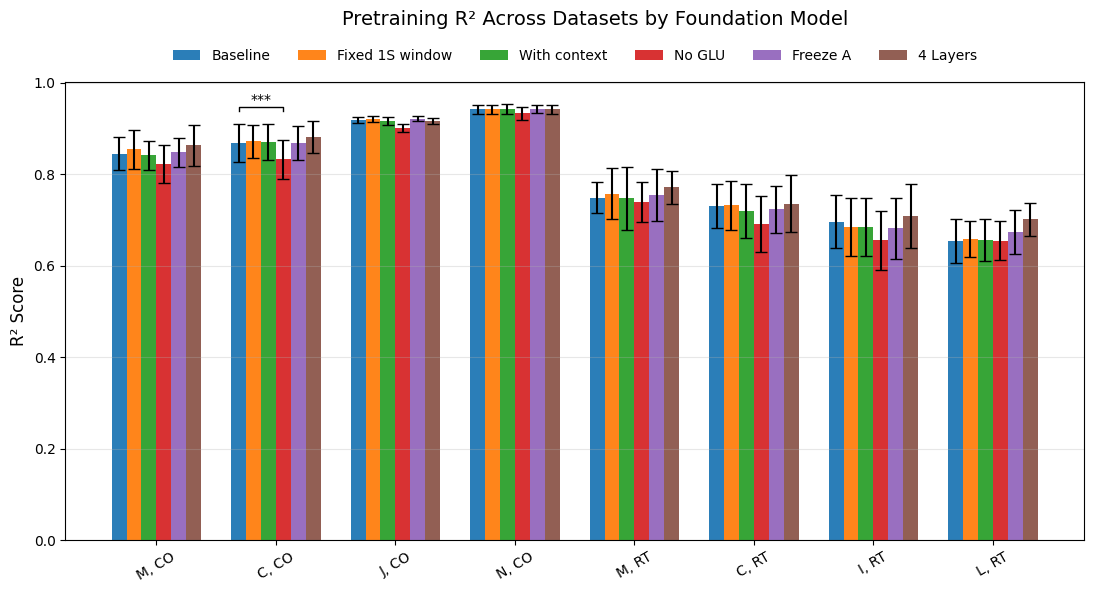

In [10]:
PROJECT = "melinajingting-ucl/foundational_ssm_pretrain"
RUN_DISPLAY_BY_LABEL = {
    "Baseline": "l2_reaching",
    "Fixed 1S window": "l2_reaching_1Swindow",
    "With context": "l2_with_context_reaching",
    "No GLU": "l2_no_glu_reaching",
    "Freeze A": "l2_freeze_a_reaching",
    "4 Layers": "l4_reaching",
}
DATASETS = {
    "M, CO": "pm_m_co",
    "C, CO": "pm_c_co",
    "J, CO": "cs_j_co",
    "N, CO": "cs_n_co",
    "M, RT": "pm_m_rt",
    "C, RT": "pm_c_rt",
    "I, RT": "os_i_rt",
    "L, RT": "os_l_rt",
}
ALL_KEY = "val/r2/all"
MEAN_KEY = "val/r2/{ds}/mean"
STD_KEY = "val/r2/{ds}/std"

# Helpers
RUN_LABELS = list(RUN_DISPLAY_BY_LABEL.keys())                   # pretty labels
DATASET_LABELS = list(DATASETS.keys())
DATASET_KEYS = [DATASETS[k] for k in DATASET_LABELS]    # preserve label order
RELOAD_DATA = False  # whether to re-query wandb even if CSV exists

api_key = os.environ.get("WANDB_API_KEY")
api = wandb.Api()


rows = []
if not os.path.exists("results/pretrain_r2_summary.csv") or RELOAD_DATA == True:
    for run_pretty, run_name in RUN_DISPLAY_BY_LABEL.items():
        # Select by run display name; if duplicate names exist, take the latest finished
        runs = api.runs(PROJECT, filters={"display_name": run_name})
        run = None
        if runs:
            # Prefer finished runs; else take the first
            finished = [r for r in runs if r.state == "finished"]
            run = finished[0] if finished else runs[0]
        if run is None:
            rows.append({"run": run_name, "error": "not found"})
            continue

        row = {"run": run_name}
        # All metric
        row[ALL_KEY] = get_summary_value(run, ALL_KEY)
        # Dataset metrics
        for ds_pretty, ds in DATASETS.items():
            row[MEAN_KEY.format(ds=ds)] = get_summary_value(run, MEAN_KEY.format(ds=ds))
            row[STD_KEY.format(ds=ds)] = get_summary_value(run, STD_KEY.format(ds=ds))
        rows.append(row)

    results_df = pd.DataFrame(rows)
    # Order columns: run, all, then dataset means/stds in requested order
    cols = ["run", ALL_KEY]
    for ds_pretty, ds in DATASETS.items():
        cols += [MEAN_KEY.format(ds=ds), STD_KEY.format(ds=ds)]
    results_df = results_df.reindex(columns=cols)
    results_df.to_csv("results/pretrain_r2_summary.csv", index=False)
else:
    results_df = pd.read_csv("results/pretrain_r2_summary.csv")

# Collect finished runs per pretty label for significance sampling
run_samples = gather_run_samples(api, PROJECT, RUN_DISPLAY_BY_LABEL)

# Plot grouped bars per dataset with models (RUN_LABELS) as groups within each dataset
fig = plt.figure(figsize=(12, 6))
x = np.arange(len(DATASET_LABELS))
C = len(RUN_LABELS)
width = min(0.75 / max(C, 1), 0.22)
offsets = (np.arange(C) - (C - 1) / 2.0) * width
colors = plt.cm.tab10.colors
model_colors = {label: colors[i % len(colors)] for i, label in enumerate(RUN_LABELS)}

bar_tops = {}  # (ds_idx, label) -> top y value
for i, (pretty_label, run_name) in enumerate(RUN_DISPLAY_BY_LABEL.items()):
    means = results_df[results_df['run'] == run_name][[MEAN_KEY.format(ds=ds_key) for ds_key in DATASET_KEYS]].values.flatten()
    stds = results_df[results_df['run'] == run_name][[STD_KEY.format(ds=ds_key) for ds_key in DATASET_KEYS]].values.flatten()
    bars = plt.bar(x + offsets[i], means, width=width, yerr=stds, capsize=4, alpha=0.95, label=pretty_label, color=model_colors[pretty_label])
    for j, b in enumerate(bars):
        bar_tops[(j, pretty_label)] = b.get_height()


ax = plt.gca()
max_height_by_ds = {j: 0.0 for j in range(len(DATASET_LABELS))}
for j, ds_key in enumerate(DATASET_KEYS):
    # Build samples per model for this dataset using per-recording values with fallback
    samples = build_samples_per_model(run_samples, ds_key, results_df, RUN_DISPLAY_BY_LABEL)
    # Annotate significance: Baseline vs each other model
    annotate_significance_pairs(ax, j, samples, RUN_LABELS, x, offsets, bar_tops, baseline_label='Baseline')

# Labels and legend
plt.xticks(x, DATASET_LABELS, rotation=30)
plt.ylabel('R² Score', fontsize=12)
# Legend at top using pretty run labels
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=6, frameon=False)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout(rect=[0, 0, 0.92, 0.95])
plt.suptitle('Pretraining R² Across Datasets by Foundation Model', fontsize=14)

# Save figure
WRITE_FIG_DIR = '/cs/student/projects1/ml/2024/mlaimon/UCL-ML-Thesis/Writeup/figures'
os.makedirs(WRITE_FIG_DIR, exist_ok=True)
fig.savefig(os.path.join(WRITE_FIG_DIR, 'pretrain_r2.png'), dpi=300, bbox_inches='tight')

plt.show()

## Downstream sweep results (wandb: foundational_ssm_downstream_sweep)

Fetch finished runs, extract `final/r2/*/mean`, aggregate per dataset/task across configurations, and plot comparisons.

mc_rtt_prepend
pm_center_out
mc_area2bump_prepend


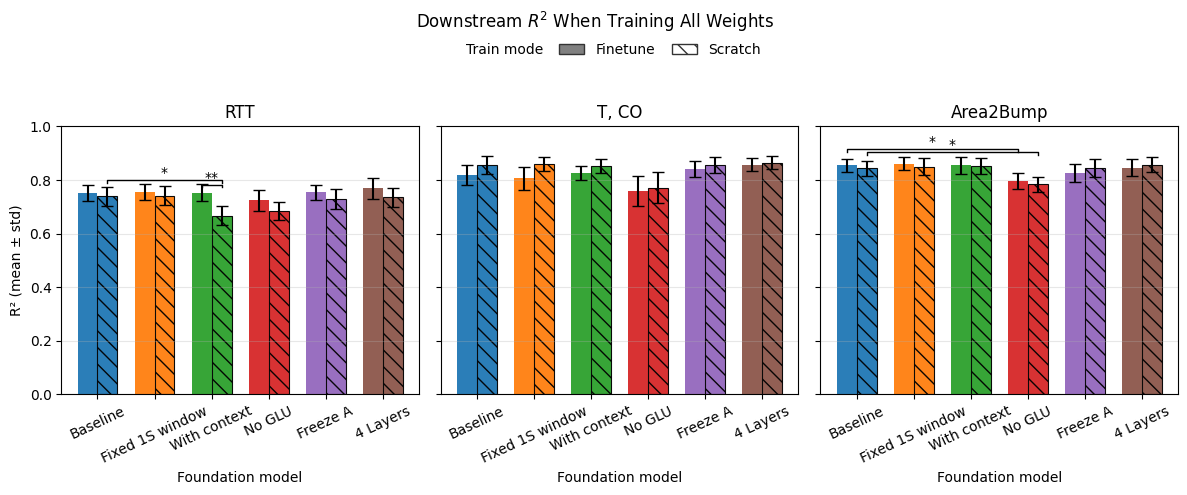

mc_rtt_prepend
pm_center_out
mc_area2bump_prepend


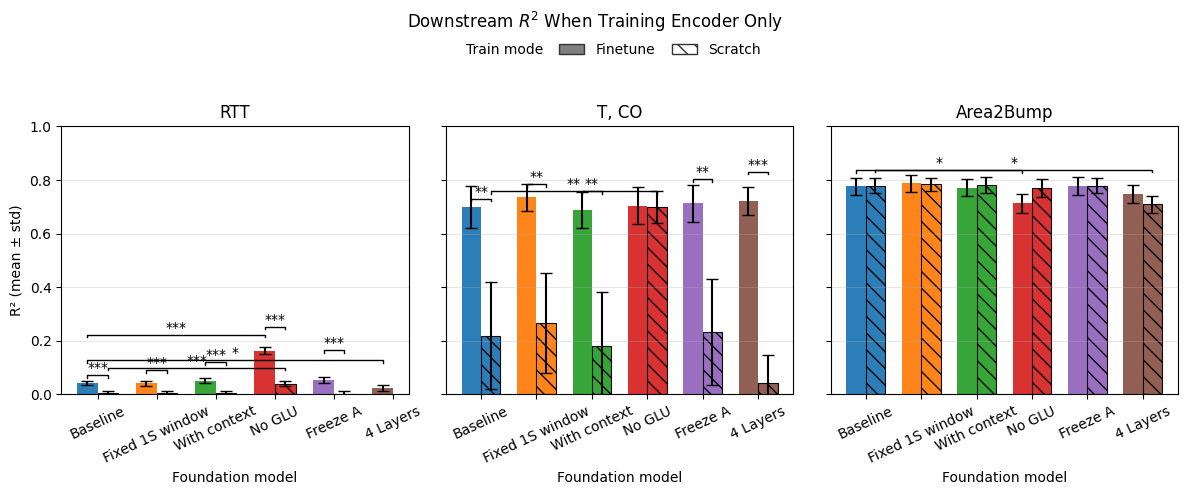

In [59]:
from typing import Dict, List, Tuple, Optional

# Save downstream figures to Writeup/figures
WRITE_FIG_DIR = '/cs/student/projects1/ml/2024/mlaimon/UCL-ML-Thesis/Writeup/figures'
os.makedirs(WRITE_FIG_DIR, exist_ok=True)

# Map checkpoint_short to friendly RUN label
RUN_KEY_VALUES = list(RUN_DISPLAY_BY_LABEL.values())  # pretrain run keys (e.g., 'l2_reaching')
RUN_KEY_TO_LABEL = {v: k for k, v in RUN_DISPLAY_BY_LABEL.items()}  # key -> pretty label
RUN_KEY_ORDER = [RUN_DISPLAY_BY_LABEL[label] for label in RUN_LABELS]  # order to match pretraining figure

SUBPLOT_TASKS = {
        "RTT": "mc_rtt_prepend",
        "T, CO": "pm_center_out",
        "Area2Bump": "mc_area2bump_prepend"
    }
TRAIN_MODE_ORDER = ["finetune", "scratch"]
TRAIN_MODE_LABEL = {"finetune": "Finetune", "scratch": "Scratch"}
HATCHES = {"scratch": "\\\\"}  # finetune solid (no hatch)

# Color per checkpoint_short, harmonized to pretraining model colors
model_color_cycle = plt.cm.tab10.colors
MODEL_COLORS = {label: model_color_cycle[i % len(model_color_cycle)] for i, label in enumerate(RUN_DISPLAY_BY_LABEL.keys())}
agg_df = pd.read_csv("results/main_downstream_performances_with_std.csv")
agg_df['n'] = 6
fig_all = draw_downstream_figure(
    agg_df,
    opt_mode_value="all",
    title_suffix="(bootstrap std where n=1)",
    run_display_by_label=RUN_DISPLAY_BY_LABEL,
    subplot_tasks=SUBPLOT_TASKS,
    train_mode_order=TRAIN_MODE_ORDER,
    hatches=HATCHES,
)
if fig_all is not None:
    fig_all.savefig(os.path.join(WRITE_FIG_DIR, 'downstream_r2_all.pdf'), dpi=300, bbox_inches='tight')

fig_enc = draw_downstream_figure(
    agg_df,
    opt_mode_value="encoder_only",
    title_suffix="(bootstrap std where n=1)",
    run_display_by_label=RUN_DISPLAY_BY_LABEL,
    subplot_tasks={
        "RTT": "mc_rtt_prepend",
        "T, CO": "pm_center_out",
        "Area2Bump": "mc_area2bump_prepend"
    },
    train_mode_order=["finetune", "scratch"],
    hatches={"scratch": "\\\\"},
)
if fig_enc is not None:
    fig_enc.savefig(os.path.join(WRITE_FIG_DIR, 'downstream_r2_encoder_only.pdf'), dpi=300, bbox_inches='tight')

In [ ]:
task = 'pm_center_out'
opt_mode = 'all'
train_mode = 'finetune'
# checkpoint_shorts = ['l2_pm_checkpoint','l2_pm_co_checkpoint','l2_reaching_checkpoint','l4_reaching_checkpoint']
checkpoint_shorts = ['l2_reaching_checkpoint','l2_reaching_1Swindow_checkpoint','l2_with_context_reaching_checkpoint','l2_no_glu_reaching_checkpoint','l2_freeze_a_reaching_checkpoint','l4_reaching_checkpoint']
tasks = ['mc_rtt_prepend', 'pm_center_out', 'mc_area2bump_prepend']

for checkpoint_short in checkpoint_shorts:
    latex_string = ''
    for task in tasks:
        mask = (agg_df['task'] == task) & (agg_df['opt_mode'] == opt_mode) & (agg_df['checkpoint_short']==checkpoint_short) & (agg_df['train_mode']==train_mode)

        row = agg_df[mask]
        latex_string += f"& ${row['r2_mean'].values[0].round(3)} \\pm {row['r2_std'].values[0].round(3)}$ "
    print(f" {latex_string}\\\\")

l2_reaching_checkpoint: & $0.75 \pm 0.03$ & $0.82 \pm 0.037$ & $0.855 \pm 0.025$ \\
l2_reaching_1Swindow_checkpoint: & $0.757 \pm 0.03$ & $0.806 \pm 0.043$ & $0.861 \pm 0.025$ \\
l2_with_context_reaching_checkpoint: & $0.752 \pm 0.032$ & $0.826 \pm 0.028$ & $0.856 \pm 0.032$ \\
l2_no_glu_reaching_checkpoint: & $0.724 \pm 0.04$ & $0.759 \pm 0.056$ & $0.796 \pm 0.029$ \\
l2_freeze_a_reaching_checkpoint: & $0.754 \pm 0.027$ & $0.841 \pm 0.03$ & $0.825 \pm 0.034$ \\
l4_reaching_checkpoint: & $0.769 \pm 0.039$ & $0.857 \pm 0.025$ & $0.847 \pm 0.032$ \\


In [ ]:
& $0.75 \pm 0.03$ & $0.82 \pm 0.037$ & $0.855 \pm 0.025$ \\
& $0.757 \pm 0.03$ & $0.806 \pm 0.043$ & $0.861 \pm 0.025$ \\
& $0.752 \pm 0.032$ & $0.826 \pm 0.028$ & $0.856 \pm 0.032$ \\
& $0.724 \pm 0.04$ & $0.759 \pm 0.056$ & $0.796 \pm 0.029$ \\
& $0.754 \pm 0.027$ & $0.841 \pm 0.03$ & $0.825 \pm 0.034$ \\
& $0.769 \pm 0.039$ & $0.857 \pm 0.025$ & $0.847 \pm 0.032$ \\

In [51]:
task = 'pm_center_out'
opt_mode = 'all'
train_mode = 'finetune'
# checkpoint_shorts = ['l2_pm_checkpoint','l2_pm_co_checkpoint','l2_reaching_checkpoint','l4_reaching_checkpoint']
checkpoint_shorts = ['l2_reaching_checkpoint','l2_no_glu_reaching_checkpoint','l4_reaching_checkpoint']
tasks = ['mc_rtt_prepend', 'pm_center_out', 'mc_area2bump_prepend']

for checkpoint_short in checkpoint_shorts:
    latex_string = ''
    for task in tasks:
        mask = (agg_df['task'] == task) & (agg_df['opt_mode'] == opt_mode) & (agg_df['checkpoint_short']==checkpoint_short) & (agg_df['train_mode']==train_mode)

        row = agg_df[mask]
        latex_string += f"& ${row['r2_mean'].values[0].round(3)} \\pm {row['r2_std'].values[0].round(3)}$ "
    print(f"{latex_string}\\\\")

& $0.75 \pm 0.03$ & $0.82 \pm 0.037$ & $0.855 \pm 0.025$ \\
& $0.724 \pm 0.04$ & $0.759 \pm 0.056$ & $0.796 \pm 0.029$ \\
& $0.769 \pm 0.039$ & $0.857 \pm 0.025$ & $0.847 \pm 0.032$ \\


In [ ]:
& $0.75 \pm 0.03$ & $0.82 \pm 0.037$ & $0.855 \pm 0.025$ \\
& $0.724 \pm 0.04$ & $0.759 \pm 0.056$ & $0.796 \pm 0.029$ \\
& $0.769 \pm 0.039$ & $0.857 \pm 0.025$ & $0.847 \pm 0.032$ \\

In [56]:
task = 'pm_center_out'
opt_mode = 'all'
train_mode = ['finetune','scratch']
checkpoint_shorts = ['l2_pm_checkpoint','l2_pm_co_checkpoint','l2_reaching_checkpoint']
mask = (agg_df['task'] == task) & (agg_df['opt_mode'] == opt_mode) & (agg_df['checkpoint_short'].isin(checkpoint_shorts)) & (agg_df['train_mode'].isin(train_mode))
agg_df[mask]

,checkpoint_short,train_mode,opt_mode,task,r2_mean,r2_std,n,r2_sample_source
8,l2_pm_checkpoint,finetune,all,pm_center_out,0.812590,0.048852,6,NaN
10,l2_pm_checkpoint,scratch,all,pm_center_out,0.853030,0.037257,6,NaN
12,l2_pm_co_checkpoint,finetune,all,pm_center_out,0.832479,0.045082,6,NaN
14,l2_pm_co_checkpoint,scratch,all,pm_center_out,0.848695,0.031276,6,NaN
20,l2_reaching_checkpoint,finetune,all,pm_center_out,0.819847,0.036673,6,NaN
22,l2_reaching_checkpoint,scratch,all,pm_center_out,0.854737,0.034135,6,NaN


In [58]:
task = 'mc_rtt_prepend'
opt_mode = 'all'
train_mode = ['finetune','scratch']
checkpoint_shorts = ['l2_os_indy_checkpoint','l2_reaching_checkpoint']
mask = (agg_df['task'] == task) & (agg_df['opt_mode'] == opt_mode) & (agg_df['checkpoint_short'].isin(checkpoint_shorts)) & (agg_df['train_mode'].isin(train_mode))
agg_df[mask]

,checkpoint_short,train_mode,opt_mode,task,r2_mean,r2_std,n,r2_sample_source
52,l2_os_indy_checkpoint,finetune,all,mc_rtt_prepend,0.749941,0.030015,6,bootstrap
53,l2_os_indy_checkpoint,scratch,all,mc_rtt_prepend,0.737294,0.033532,6,bootstrap
64,l2_reaching_checkpoint,finetune,all,mc_rtt_prepend,0.750357,0.030412,6,bootstrap
68,l2_reaching_checkpoint,scratch,all,mc_rtt_prepend,0.738745,0.035925,6,bootstrap


mc_area2bump_prepend


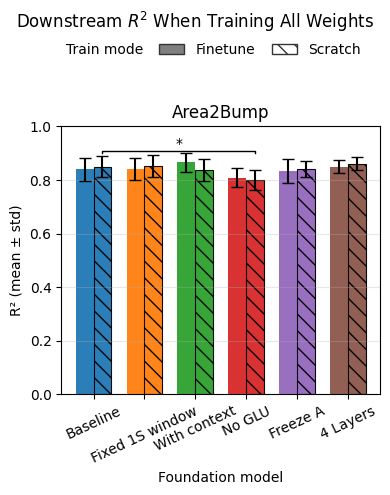

In [13]:
fig_enc = draw_downstream_figure(
    agg_df,
    opt_mode_value="all",
    title_suffix="(bootstrap std where n=1)",
    run_display_by_label=RUN_DISPLAY_BY_LABEL,
    subplot_tasks={
        "Area2Bump": "mc_area2bump_prepend"
    },
    train_mode_order=["finetune", "scratch"],
    hatches={"scratch": "\\\\"},
)

mc_rtt_prepend
pm_center_out


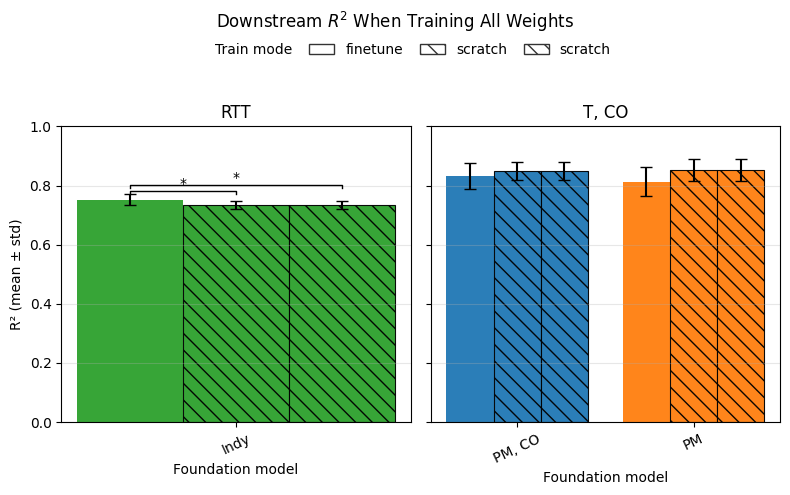

In [ ]:

def draw_downstream_figure(
    df,
    opt_mode_value: str,
    title_suffix: str,
    run_display_by_label: Dict[str, str],
    subplot_tasks: Optional[List[str]] = None,
    train_mode_order: Optional[List[str]] = None,
    hatches: Optional[Dict[str, str]] = None,
    color_cycle=None,
):
    """Plot downstream bars filtered/order-matched to pretraining, without global state.

    Args:
      df: aggregated dataframe with columns [checkpoint_short, train_mode, opt_mode, task, r2_mean, r2_std, n].
      opt_mode_value: 'all' or 'encoder_only'.
      title_suffix: subtitle text.
      run_display_by_label: mapping of pretty label -> pretrain run key (e.g., 'Baseline' -> 'l2_reaching').
      subplot_tasks: dict of {subplot_title: task_key} to show.
      train_mode_order: order of train modes; any length supported (default ['finetune','scratch']).
      hatches: bar hatch mapping per train mode (default {'scratch': '\\\\'}).
      color_cycle: optional sequence of colors.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch

    if subplot_tasks is None:
        subplot_tasks = {"RTT": "pm_random_target", "T, CO": "pm_center_out", "Area2Bump": "mc_area2bump_prepend"}
    if train_mode_order is None:
        train_mode_order = ["finetune", "scratch"]
    if hatches is None:
        hatches = {"scratch": "\\\\"}
    if color_cycle is None:
        color_cycle = plt.cm.tab10.colors

    # Derive pretraining label/key/order and color map locally
    run_labels = list(run_display_by_label.keys())
    run_key_values = list(run_display_by_label.values())  # keys used in checkpoint_short (trimmed)
    run_key_to_label = {v: k for k, v in run_display_by_label.items()}
    run_key_order = [run_display_by_label[label] for label in run_labels]
    model_colors = {label: color_cycle[i % len(color_cycle)] for i, label in enumerate(run_labels)}

    sub = prep_plot_data(df, opt_mode_value=opt_mode_value, subplot_tasks=subplot_tasks)

    # Fallback color mapping by checkpoint order among the filtered data
    checkpoint_list = sorted([c for c in sub["checkpoint_short"].dropna().unique()])
    fallback_palette = sns.color_palette("tab10", n_colors=max(1, len(checkpoint_list)))
    fallback_by_ckpt = {ck: fallback_palette[i % len(fallback_palette)] for i, ck in enumerate(checkpoint_list)}

    # Dynamic bar sizing/offsets by number of train modes
    M = max(1, len(train_mode_order))
    width = 0.8 / M
    def mode_offset(k: int) -> float:
        return (k - (M - 1) / 2) * width

    fig, axes = plt.subplots(1, len(subplot_tasks), figsize=(4 * len(subplot_tasks), 5), sharey=True)
    if len(subplot_tasks) == 1:
        axes = [axes]

    for ax, (task_title, task) in zip(axes, subplot_tasks.items()):
        tdf = sub[sub["task"] == task].copy()
        print(task)
        if tdf.empty:
            ax.set_title(task_title)
            ax.text(0.5, 0.5, "No data", ha='center', va='center')
            ax.axis('off')
            continue
        # Only checkpoints whose trimmed name matches pretraining run keys
        tdf = tdf.assign(ck_trimmed=tdf["checkpoint_short"].astype(str).str.replace("_checkpoint", "", regex=False))
        tdf = tdf[tdf["ck_trimmed"].isin(run_key_values)]
        if tdf.empty:
            ax.set_title(task_title)
            ax.text(0.5, 0.5, "No matching pretrain checkpoints", ha='center', va='center')
            ax.axis('off')
            continue
        # Order checkpoints to match pretraining figure order
        trimmed_to_ck = {ct: ck for ck, ct in zip(tdf["checkpoint_short"].values, tdf["ck_trimmed"].values)}
        ckpts = [trimmed_to_ck[k] for k in run_key_order if k in trimmed_to_ck]
        x = np.arange(len(ckpts))
        bar_tops = {}

        # Bars per train mode
        for k, tm in enumerate(train_mode_order):
            sdf = tdf[tdf["train_mode"] == tm]
            means = [sdf[sdf["checkpoint_short"] == ck]["r2_mean"].mean() if not sdf[sdf["checkpoint_short"] == ck].empty else np.nan for ck in ckpts]
            stds = [sdf[sdf["checkpoint_short"] == ck]["r2_std"].mean() if not sdf[sdf["checkpoint_short"] == ck].empty else 0.0 for ck in ckpts]
            positions = x + mode_offset(k)
            colors = [
                color_for_checkpoint(ck.replace('_checkpoint',''), model_colors, run_key_to_label, fallback_by_ckpt)
                for ck in ckpts
            ]
            bars = ax.bar(positions, means, width=width, yerr=stds, capsize=4, color=colors, alpha=0.95)
            for b, j in zip(bars, range(len(ckpts))):
                bar_tops[(j, tm)] = b.get_height()
            hatch = hatches.get(tm, "")
            if hatch:
                for b in bars:
                    b.set_hatch(hatch)
                    b.set_edgecolor("black")
                    b.set_linewidth(0.8)

        # X labels: pretty labels in pretraining order corresponding to present checkpoints
        xlabels = [ckpt_to_label(ck.replace('_checkpoint',''), run_key_to_label) for ck in ckpts]
        ax.set_xticks(x)
        ax.set_xticklabels(xlabels, rotation=25)
        ax.set_title(task_title)
        ax.set_ylim(0,1)
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_xlabel("Foundation model")

        # Helper: get summary stats for a group
        def group_summary(ck, tm):
            row = tdf[(tdf["checkpoint_short"] == ck) & (tdf["train_mode"] == tm)]
            if row.empty:
                return None
            r = row.iloc[0]
            m, s, n = float(r["r2_mean"]), float(r["r2_std"]), int(r["n"])
            return m, s, n

        # Within-checkpoint tests: base mode (first) vs others using summary stats
        if len(train_mode_order) > 1:
            pvals, pairs = [], []
            base_mode = train_mode_order[0]
            idx_base = 0
            for j, ck in enumerate(ckpts):
                base_stats = group_summary(ck, base_mode)
                for k in range(1, len(train_mode_order)):
                    tm_other = train_mode_order[k]
                    other_stats = group_summary(ck, tm_other)
                    if base_stats and other_stats:
                        p = welch_p_from_summary(*base_stats, *other_stats)
                        if p is not None:
                            pvals.append(p)
                            pairs.append((j, idx_base, k))
            if pvals:
                qvals = bh_adjust(pvals)
                level = 0
                for (j, base_k, other_k), q in zip(pairs, qvals):
                    stars = p_to_stars(q)
                    if not stars:
                        continue
                    x1 = x[j] + mode_offset(base_k)
                    x2 = x[j] + mode_offset(other_k)
                    tm1 = train_mode_order[base_k]
                    tm2 = train_mode_order[other_k]
                    base_h = max(bar_tops.get((j, tm1), 0), bar_tops.get((j, tm2), 0))
                    annotate(ax, x1, x2, base_h + 0.02 + level*0.02, stars)
                    level += 1

        # Across checkpoints (baseline vs others) per train mode
        for tm in train_mode_order:
            if not ckpts:
                continue
            j0 = 0  # baseline is first in pretraining order present
            base_ck = ckpts[j0]
            pvals2, pairs2 = [], []
            base_stats = group_summary(base_ck, tm)
            for j1, ck in enumerate(ckpts[1:], start=1):
                other_stats = group_summary(ck, tm)
                if base_stats and other_stats:
                    p = welch_p_from_summary(*base_stats, *other_stats)
                    if p is not None:
                        pvals2.append(p)
                        pairs2.append((j0, j1, tm))
            if pvals2:
                q2 = bh_adjust(pvals2)
                level2 = 0
                for (j0_, j1_, tmv), q in zip(pairs2, q2):
                    stars = p_to_stars(q)
                    if not stars:
                        continue
                    pos_offset = mode_offset(train_mode_order.index(tmv))
                    x1 = x[j0_] + pos_offset
                    x2 = x[j1_] + pos_offset
                    base_h = max(bar_tops.get((j0_, tmv), 0), bar_tops.get((j1_, tmv), 0))
                    annotate(ax, x1, x2, base_h + 0.05 + level2*0.025, stars)
                    level2 += 1

    axes[0].set_ylabel("R² (mean ± std)")
    fig.suptitle(f"Downstream " + r'$R^2$' + f" When Training {'All Weights' if opt_mode_value=="all" else "Encoder Only"}", y=0.98)

    # Dynamic legend for train modes
    legend_handles = [Line2D([], [], color='none', label='Train mode')]
    for tm in train_mode_order:
        legend_handles.append(Patch(facecolor='white', edgecolor='0.2', hatch=hatches.get(tm, ''), label=tm))

    fig.legend(legend_handles, [h.get_label() for h in legend_handles], loc='upper center', bbox_to_anchor=(0.5, 0.94), ncol=min(4, 1+len(legend_handles)), frameon=False, columnspacing=1.2, handlelength=1.8)
    fig.tight_layout(rect=[0, 0, 1, 0.90])
    plt.show()
    return fig


fig_enc = draw_downstream_figure(
    agg_df,
    opt_mode_value="all",
    title_suffix="(bootstrap std where n=1)",
    run_display_by_label={
        "PM, CO": "l2_pm_co",
        "PM": "l2_pm",
        "Indy": "l2_os_indy",
        },
    subplot_tasks={
        "RTT": "mc_rtt_prepend",
        "T, CO": "pm_center_out",
    },
    train_mode_order=["finetune", "scratch", "scratch"],
    hatches={"scratch": "\\\\"},
)
# if fig_enc is not None:
#     fig_enc.savefig(os.path.join(WRITE_FIG_DIR, 'downstream_r2_encoder_only.png'), dpi=300, bbox_inches='tight')

In [ ]:
# Build LaTeX tables for downstream results (opt_mode=all and encoder_only)
import os
import pandas as pd

WRITE_TABLE_DIR = '/cs/student/projects1/ml/2024/mlaimon/UCL-ML-Thesis/Writeup/tables'
os.makedirs(WRITE_TABLE_DIR, exist_ok=True)

# Helper: format mean ± std or --
def fmt_ms(m, s):
    if pd.isna(m):
        return "--"
    s = 0.0 if pd.isna(s) else s
    return f"${m:.3f} \\pm {s:.3f}$"

# Map checkpoint_short (trimmed) to pretty model label and to num_params from pretrain runs
trim_to_label = {v: k for k, v in RUN_DISPLAY_BY_LABEL.items()}

# Try to gather model/num_params from pretraining runs (fallback to NaN)
api = wandb.Api()
num_params_by_label = {}
for pretty, run_key in RUN_DISPLAY_BY_LABEL.items():
    try:
        runs = api.runs(PROJECT, filters={"display_name": run_key})
        r = [x for x in runs if x.state == 'finished']
        run = r[0] if r else (runs[0] if runs else None)
        num_params_by_label[pretty] = run.summary.get('model/num_params') if run is not None else None
    except Exception:
        num_params_by_label[pretty] = None

# Allow adding external baselines in the following form (example included)
external_rows = {
  "all": [
    {
      "name": "MLP",
      "train_mode": "scratch",
      "pm_center_out": {
        "mean": 0.7976,
        "std": 0.0220
      },
      "mc_area2bump_prepend": {
        "mean": 0.4179,
        "std": None
      },
      "num_params": None
    },
    {
      "name": "S4D",
      "train_mode": "scratch",
      "pm_center_out": {
        "mean": 0.8526,
        "std": 0.0243
      },
      "mc_area2bump_prepend": {
        "mean": 0.3942,
        "std": None
      },
      "num_params": None
    },
    {
      "name": "POSSM-S4D-SS",
      "train_mode": "scratch",
      "pm_center_out": {
        "mean": 0.8838,
        "std": 0.0171
      },
      "mc_area2bump_prepend": {
        "mean": 0.8163,
        "std": None
      },
      "num_params": "0.41M"
    },
    {
      "name": "POYO-SS",
      "train_mode": "scratch",
      "pm_center_out": {
        "mean": 0.8705,
        "std": 0.0193
      },
      "mc_area2bump_prepend": {
        "mean": 0.4974,
        "std": None
      },
      "num_params": None
    },
    {
      "name": "o-POSSM-S4D (FT)",
      "train_mode": "scratch",
      "pm_center_out": {
        "mean": 0.9069,
        "std": 0.0120
      },
      "mc_area2bump_prepend": {
        "mean": 0.8701,
        "std": None
      },
      "num_params": "4.5M"
    },
    {
      "name": "POYO-1 (FT)",
      "train_mode": "scratch",
      "pm_center_out": {
        "mean": 0.8859,
        "std": 0.0275
      },
      "mc_area2bump_prepend": {
        "mean": 0.8676,
        "std": None
      },
      "num_params": None
    },
    {
      "name": "NDT-2*(FT)",
      "train_mode": "scratch",
      "pm_center_out": {
        "mean": 0.6549,
        "std": 0.0290
      },
      "mc_area2bump_prepend": {
        "mean": 0.8237,
        "std": None
      },
      "num_params": None
    }
  ],
  "encoder_only": [
    {
      "name": "POYO-1 (UI)",
      "train_mode": "scratch",
      "pm_center_out": {
        "mean": 0.8214,
        "std": 0.0277
      },
      "mc_area2bump_prepend": {
        "mean": 0.7666,
        "std": None
      },
      "num_params": None
    },
    {
      "name": "o-POSSM-S4D (UI)",
      "train_mode": "scratch",
      "pm_center_out": {
        "mean": 0.8739,
        "std": 0.0138
      },
      "mc_area2bump_prepend": {
        "mean": 0.7941,
        "std": None
      },
      "num_params": None
    }
  ]
}

# Helper to format an external entry's task metric which may be nested dict
# ext_val can be: None, float, or dict with keys {'mean': float, 'std': float|None}
def fmt_ext(ext, key):
    v = ext.get(key, None)
    if v is None:
        return "--"
    if isinstance(v, dict):
        m = v.get("mean", float('nan'))
        s = v.get("std", float('nan'))
        s = 0.0 if (s is None or pd.isna(s)) else s
        return fmt_ms(m, s) if pd.notna(m) else "--"
    return f"{float(v):.3f}" if pd.notna(v) else "--"

# Build tables for each opt_mode
for opt_mode_value, fname in [("all", "downstream_all.tex"), ("encoder_only", "downstream_encoder_only.tex")]:
    sub = prep_plot_data(agg_df, opt_mode_value=opt_mode_value, subplot_tasks={
        "RTT": "mc_rtt_prepend",
        "T-CO": "pm_center_out",
        "H-CO": "mc_area2bump_prepend",
    })
    # Derive trimmed name and pretty label
    sub = sub.assign(ck_trimmed=sub["checkpoint_short"].astype(str).str.replace("_checkpoint", "", regex=False))
    sub["Model"] = sub["ck_trimmed"].map(trim_to_label)
    # Aggregate pivot: we need mean/std per task and train_mode per model
    keep_tasks = ["pm_center_out", "mc_area2bump_prepend", "mc_rtt_prepend"]
    sub = sub[sub["task"].isin(keep_tasks)]

    # Build a dict keyed by (Model, train_mode) -> task -> (mean,std)
    records = {}
    for (model, tm, task), g in sub.groupby(["Model", "train_mode", "task"]):
        m = float(g["r2_mean"].iloc[0]) if not g.empty else float('nan')
        s = float(g["r2_std"].iloc[0]) if not g.empty else float('nan')
        records.setdefault((model, tm), {})[task] = (m, s)

    # Assemble rows in required order
    rows = []
    # Scratch: only Baseline, No GLU, 4 Layers
    scratch_models = ["Baseline", "No GLU", "4 Layers"]
    for model in scratch_models:
        tm = "scratch"
        vals = records.get((model, tm), {})
        row = {
            "Model": model,
            "\\#Params": num_params_by_label.get(model)
        }
        row["T-CO"] = fmt_ms(*(vals.get("pm_center_out", (float('nan'), float('nan')))))
        row["H-CO"] = fmt_ms(*(vals.get("mc_area2bump_prepend", (float('nan'), float('nan')))))
        row["RTT"] = fmt_ms(*(vals.get("mc_rtt_prepend", (float('nan'), float('nan')))))
        row["Train"] = "Scratch"
        rows.append(row)

    # External scratch baselines (select by current opt_mode)
    for ext in external_rows.get(opt_mode_value, []):
        if str(ext.get("train_mode", "")).lower() != "scratch":
            continue
        row = {
            "Model": ext.get("name", "External"),
            "\\#Params": ext.get("num_params", None),
            "T-CO": fmt_ext(ext, 'pm_center_out'),
            "H-CO": fmt_ext(ext, 'mc_area2bump_prepend'),
            "RTT": fmt_ext(ext, 'mc_rtt_prepend'),
            "Train": "Scratch"
        }
        rows.append(row)

    # Separator marker row (we'll convert to \midrule in the LaTeX string)
    rows.append({"Model": "__MIDRULE__", "\\#Params": "", "T-CO": "", "H-CO": "", "RTT": "", "Train": ""})

    # Finetuned: everything that is finetuned
    finetune_models = list(RUN_DISPLAY_BY_LABEL.keys())
    for model in finetune_models:
        tm = "finetune"
        vals = records.get((model, tm), {})
        row = {
            "Model": model,
            "\\#Params": num_params_by_label.get(model)
        }
        row["T-CO"] = fmt_ms(*(vals.get("pm_center_out", (float('nan'), float('nan')))))
        row["H-CO"] = fmt_ms(*(vals.get("mc_area2bump_prepend", (float('nan'), float('nan')))))
        row["RTT"] = fmt_ms(*(vals.get("mc_rtt_prepend", (float('nan'), float('nan')))))
        row["Train"] = "Finetune"
        rows.append(row)

    # External finetune baselines if provided
    for ext in external_rows.get(opt_mode_value, []):
        if str(ext.get("train_mode", "")).lower() != "finetune":
            continue
        row = {
            "Model": ext.get("name", "External"),
            "\\#Params": ext.get("num_params", None),
            "T-CO": fmt_ext(ext, 'pm_center_out'),
            "H-CO": fmt_ext(ext, 'mc_area2bump_prepend'),
            "RTT": fmt_ext(ext, 'mc_rtt_prepend'),
            "Train": "Finetune"
        }
        rows.append(row)

    table = pd.DataFrame(rows, columns=["Model", "\\#Params", "T-CO", "H-CO", "RTT", "Train"]).fillna("")

    # Convert to LaTeX and robustly insert \midrule after the scratch block
    tex_lines = table.to_latex(index=False, escape=False).splitlines()
    new_lines = []
    for line in tex_lines:
        if line.strip().startswith("__MIDRULE__"):
            # Replace the whole row with a LaTeX midrule
            new_lines.append("\\midrule")
        else:
            new_lines.append(line)
    tex = "\n".join(new_lines)

    out_path = os.path.join(WRITE_TABLE_DIR, fname)
    with open(out_path, 'w') as f:
        f.write(tex)
    print(f"Wrote downstream LaTeX table to: {out_path}")

Wrote downstream LaTeX table to: /cs/student/projects1/ml/2024/mlaimon/UCL-ML-Thesis/Writeup/tables/downstream_all.tex
Wrote downstream LaTeX table to: /cs/student/projects1/ml/2024/mlaimon/UCL-ML-Thesis/Writeup/tables/downstream_encoder_only.tex


## Bootstrap caching and persistence

- Storage: keep `r2_samples` as a Python list[float] so Parquet (pyarrow) stores it as a nested list cleanly.
- Skipping recompute: only compute bootstraps for rows missing a bootstrap patch or with fewer than B samples.
- Persistence: write the patched table to a Parquet file and reuse it on subsequent runs.

Below utilities patch `agg_df` with bootstrap stats, merge from an existing cache if provided, compute only the missing ones, and save back.